# Exploration of factors influencing students’ PISA scores in philippines with Machine Learning approaches : Classification Models 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_score

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import xgboost as xg 
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression


# Import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
accuracy_score, plot_roc_curve, roc_auc_score, recall_score, \
precision_score, f1_score, classification_report

#interpretml 
from interpret import show
from interpret.data import Marginal
from interpret.glassbox import ExplainableBoostingClassifier
from interpret.perf import RegressionPerf
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())

# Feature Importance 
import shap

In [2]:
#Import datasets
train_philippines = pd.read_csv('datasets/train_pisa2018_philippines.csv')
test_philippines = pd.read_csv('datasets/test_pisa2018_philippines.csv')

In [3]:
train_philippines.head(2)

CNTSTUID  GRADE    AGE         ISCEDL  PARED  HISEI   IMMIG  \
0  60802903.0    0.0  15.58  ISCED level 2   16.0  28.48  Native   
1  60803247.0    0.0  15.42  ISCED level 2   10.0  44.14  Native   

                    REPEAT    ESCS  UNDREM  ...  DISCRIM  BELONG  WVARSTRR  \
0        Repeated a  grade -0.9605    0.45  ...   0.6266 -0.7410       6.0   
1  Did not repeat a  grade -2.2282   -0.60  ...   1.2675 -0.5707      46.0   

   GENDER      MATH   SCIENCE      READ  TOTALSCORE  Is_MISCED_5B  \
0       0  240.8811  299.2239  239.6377  259.914233             0   
1       1  414.1142  378.7488  338.4567  377.106567             0   

   Is_FISCED_5B  
0             0  
1             0  

[2 rows x 54 columns]

In [4]:
test_philippines.head(2)

CNTSTUID  GRADE    AGE         ISCEDL  PARED  HISEI   IMMIG  \
0  60805955.0    0.0  15.42  ISCED level 2   14.0  61.07  Native   
1  60803752.0    0.0  15.75  ISCED level 2   13.0  30.34  Native   

                    REPEAT    ESCS  UNDREM  ...  DISCRIM  BELONG  WVARSTRR  \
0  Did not repeat a  grade  0.0464   -0.94  ...   0.5881 -1.2565      18.0   
1  Did not repeat a  grade -1.3947   -0.94  ...   0.5881  0.0348      45.0   

   GENDER      MATH   SCIENCE      READ  TOTALSCORE  Is_MISCED_5B  \
0       0  438.0172  470.9168  442.3503  450.428100             1   
1       1  378.5762  372.2731  365.2646  372.037967             0   

   Is_FISCED_5B  
0             1  
1             0  

[2 rows x 54 columns]

In [5]:
#Check for missing values
train_philippines.isnull().sum().sum(), test_philippines.isnull().sum().sum()

(0, 0)

In [6]:
#Set 'CNTSTUID' as index
train_philippines.set_index('CNTSTUID', inplace=True)
test_philippines.set_index('CNTSTUID', inplace=True)

In [7]:
train_philippines[['TOTALSCORE']].describe()

TOTALSCORE
count  4999.000000
mean    354.325858
std      71.694206
min     142.591000
25%     301.071267
50%     343.130633
75%     398.159667
max     628.708533

## Creating target variable

Classify students' performance level based on their Pisa total score. 
OECD classify student's performance level into 6 levels.
Higher than 707.93 ==> level 6
633.33-707.93 ==> level 5
558.73 - 633.33 ==> level 4
484.14 - 558.73 ==> level 3
409.54 - 484.14 ==> level 2
lower than 409.54  ==> level 1

In this analysis, student's perfomance are classified into two groups, level 3 and above or level 2 and below. 

In [14]:
# Create funtion to classify student's performance
def assign_performance_level(data):
    if data <= 409.54:
        return '0' #lowperformance 
    else:
         return '1'  #highperformance 

In [15]:
#Apply function to data
train_philippines['PISALEVEL'] = train_philippines['TOTALSCORE'].apply(assign_performance_level)
test_philippines['PISALEVEL'] = test_philippines['TOTALSCORE'].apply(assign_performance_level)

In [16]:
#Check target distribution
train_philippines['PISALEVEL'].value_counts()

0    3932
1    1067
Name: PISALEVEL, dtype: int64

In [17]:
#Check target distribution
train_philippines['PISALEVEL'].value_counts(normalize=True).mul(100).round(2)

0    78.66
1    21.34
Name: PISALEVEL, dtype: float64

In [18]:
#Check target distribution
test_philippines['PISALEVEL'].value_counts()

0    1167
1     280
Name: PISALEVEL, dtype: int64

In [19]:
#Check target distribution
test_philippines['PISALEVEL'].value_counts(normalize=True).mul(100).round(2)

0    80.65
1    19.35
Name: PISALEVEL, dtype: float64

# Building Classification Models

In [20]:
# X and y are defined as same as regression model from previous study

In [21]:
X_train =train_philippines[['GRADE', 'HISEI', 'ESCS', 'METASUM', 'HOMEPOS', 'DISCLIMA',
       'EMOSUPS', 'TEACHINT', 'JOYREAD', 'SCREADCOMP', 'SCREADDIFF',
       'PISADIFF', 'WORKMAST', 'RESILIENCE', 'MASTGOAL', 'GCSELFEFF',
       'GCAWARE', 'ATTIMM', 'PERSPECT', 'RESPECT', 'AWACOM', 'DISCRIM',
       'BELONG', 'Is_MISCED_5B', 'Is_FISCED_5B', 'ISCEDL', 'IMMIG', 'REPEAT', 'GENDER']]
X_train = pd.get_dummies(columns=[ 'Is_MISCED_5B', 'Is_FISCED_5B', 'ISCEDL', 'IMMIG', 'REPEAT', 'GENDER'], 
                         drop_first =True, data =X_train)
y_train = train_philippines['PISALEVEL']


X_test =test_philippines[['GRADE', 'HISEI', 'ESCS', 'METASUM', 'HOMEPOS', 'DISCLIMA',
       'EMOSUPS', 'TEACHINT', 'JOYREAD', 'SCREADCOMP', 'SCREADDIFF',
       'PISADIFF', 'WORKMAST', 'RESILIENCE', 'MASTGOAL', 'GCSELFEFF',
       'GCAWARE', 'ATTIMM', 'PERSPECT', 'RESPECT', 'AWACOM', 'DISCRIM',
       'BELONG', 'Is_MISCED_5B', 'Is_FISCED_5B', 'ISCEDL', 'IMMIG', 'REPEAT', 'GENDER']]
X_test = pd.get_dummies(columns=[ 'Is_MISCED_5B', 'Is_FISCED_5B', 'ISCEDL', 'IMMIG', 'REPEAT', 'GENDER'], 
                         drop_first =True, data =X_test)
y_test = test_philippines['PISALEVEL']

## Dummy Classifier model

In [22]:
#Standardize data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

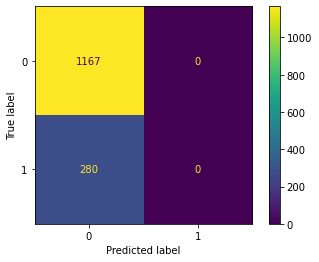

In [23]:
from sklearn.dummy import DummyClassifier
baseline_model = DummyClassifier()
baseline_model.fit(X_train_sc, y_train)
baseline_preds = baseline_model.predict(X_test_sc)
ConfusionMatrixDisplay.from_predictions(y_test, baseline_preds);

In [24]:
import warnings
warnings.filterwarnings("ignore")
print(classification_report(y_test, baseline_preds))

              precision    recall  f1-score   support

           0       0.81      1.00      0.89      1167
           1       0.00      0.00      0.00       280

    accuracy                           0.81      1447
   macro avg       0.40      0.50      0.45      1447
weighted avg       0.65      0.81      0.72      1447



## Logistic Regression

In [25]:
logreg =LogisticRegression()


parameters = [{'penalty':['none','l2']}, 
              {'C':[1, 10, 100]}]

logreg_gr = GridSearchCV(estimator = logreg,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)

logreg_gr.fit(X_train_sc, y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'penalty': ['none', 'l2']}, {'C': [1, 10, 100]}],
             scoring='accuracy')

In [26]:
preds= logreg_gr.predict(X_test_sc)

In [27]:
pd.DataFrame(logreg_gr.cv_results_).sort_values('rank_test_score').head(5)[['params','mean_test_score']]

params  mean_test_score
0  {'penalty': 'none'}         0.871578
1    {'penalty': 'l2'}         0.871578
2             {'C': 1}         0.871578
3            {'C': 10}         0.871578
4           {'C': 100}         0.871578

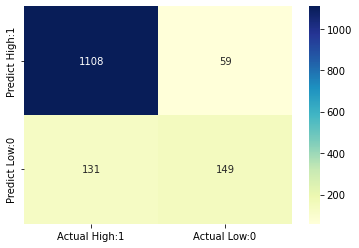

In [28]:
cm = confusion_matrix(y_test, preds)
# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual High:1', 'Actual Low:0'], 
                                 index=['Predict High:1', 'Predict Low:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [29]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1167
           1       0.72      0.53      0.61       280

    accuracy                           0.87      1447
   macro avg       0.81      0.74      0.77      1447
weighted avg       0.86      0.87      0.86      1447



In [30]:
#Get LogisticRegression
logreg =LogisticRegression(random_state= 42,)
logreg.fit(X_train_sc, y_train)
preds= logreg.predict(X_test_sc)
pd.Series(logreg.coef_[0], index = X_train.columns).sort_values(ascending=False)

METASUM                     0.517652
ATTIMM                      0.422805
HOMEPOS                     0.397811
HISEI                       0.369267
WORKMAST                    0.308631
GCAWARE                     0.296106
GRADE                       0.245543
GCSELFEFF                   0.230582
Is_FISCED_5B_1              0.211478
PERSPECT                    0.177138
JOYREAD                     0.136792
ISCEDL_ISCED level 3        0.128937
DISCLIMA                    0.052857
IMMIG_Second-Generation     0.050829
AWACOM                      0.035071
Is_MISCED_5B_1              0.032188
EMOSUPS                     0.018564
ESCS                        0.005507
BELONG                      0.001200
IMMIG_Native               -0.003057
TEACHINT                   -0.023014
RESPECT                    -0.037547
SCREADCOMP                 -0.054092
PISADIFF                   -0.075482
GENDER_1                   -0.197901
RESILIENCE                 -0.204706
MASTGOAL                   -0.251865
R

In [31]:
# coefficient dataframe
logreg_coef = pd.DataFrame(data=logreg.coef_,columns=X_train.columns).T.sort_values(by=0,ascending=False)

# Label the color the each coefficient
color = ['red' if x < 0 else 'blue' for x in logreg_coef[0]]

# Assign the color_list to new column
logreg_coef['color'] = color

logreg_coef.head()

0 color
METASUM   0.517652  blue
ATTIMM    0.422805  blue
HOMEPOS   0.397811  blue
HISEI     0.369267  blue
WORKMAST  0.308631  blue

In [32]:
# Select the highest values whether negative or positive
abs(logreg_coef[0]).sort_values(ascending=False)[:10].index

Index(['SCREADDIFF', 'DISCRIM', 'METASUM', 'REPEAT_Repeated a  grade',
       'ATTIMM', 'HOMEPOS', 'HISEI', 'WORKMAST', 'GCAWARE', 'MASTGOAL'],
      dtype='object')

Text(0.5, 1.0, 'Top 10 highest coefficient')

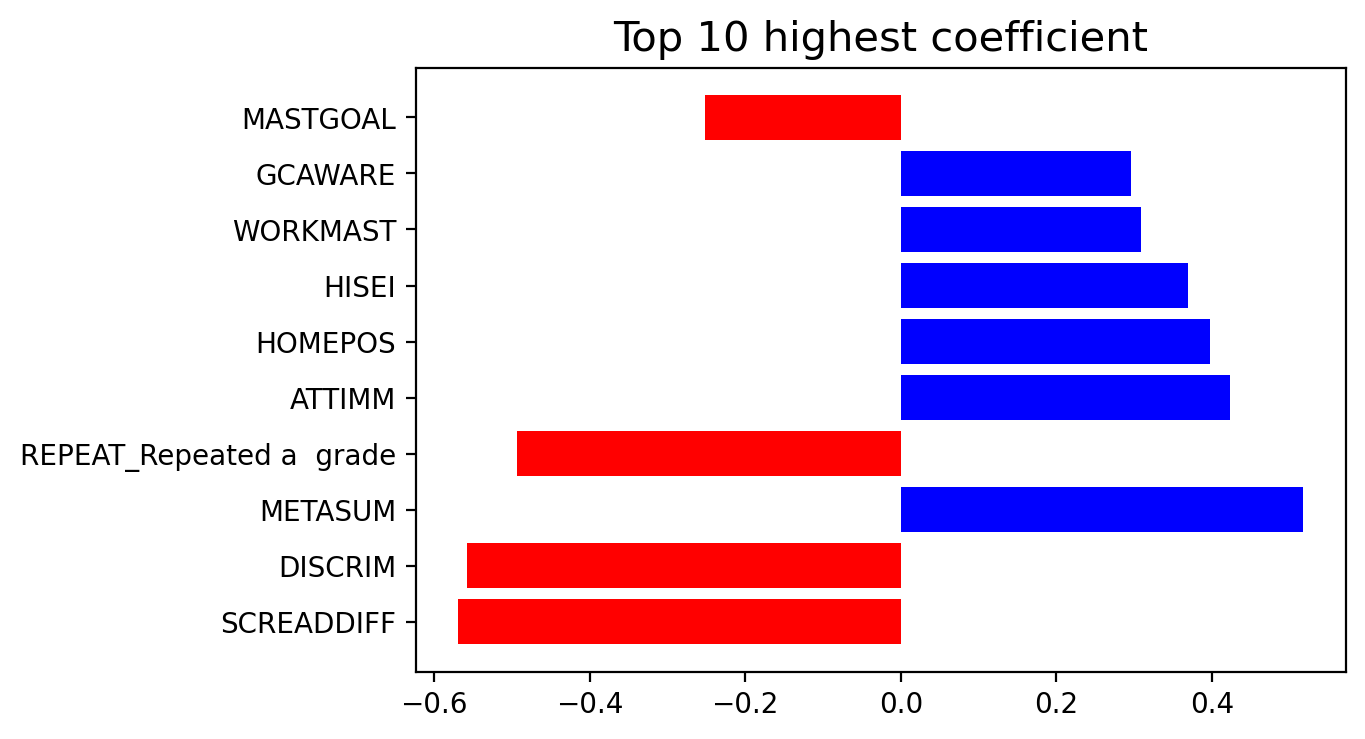

In [33]:
# Plot the coefficient of top 10 highest coefficient 
plt.figure(dpi=200)
plt.barh(logreg_coef.loc[['SCREADDIFF', 'DISCRIM', 'METASUM', 'REPEAT_Repeated a  grade',
       'ATTIMM', 'HOMEPOS', 'HISEI', 'WORKMAST', 'GCAWARE', 'MASTGOAL']].index,logreg_coef.loc[['SCREADDIFF', 'DISCRIM', 'METASUM', 'REPEAT_Repeated a  grade',
       'ATTIMM', 'HOMEPOS', 'HISEI', 'WORKMAST', 'GCAWARE', 'MASTGOAL']][0],color=logreg_coef.loc[['SCREADDIFF', 'DISCRIM', 'METASUM', 'REPEAT_Repeated a  grade',
       'ATTIMM', 'HOMEPOS', 'HISEI', 'WORKMAST', 'GCAWARE', 'MASTGOAL']]['color'])
plt.title('Top 10 highest coefficient',size=15)

## Explainable Boosting Classifier model

In [34]:
ebm = ExplainableBoostingClassifier(random_state=42, feature_names =X_train.columns)
ebm.fit(X_train, y_train)

ExplainableBoostingClassifier(feature_names=['GRADE', 'HISEI', 'ESCS',
                                             'METASUM', 'HOMEPOS', 'DISCLIMA',
                                             'EMOSUPS', 'TEACHINT', 'JOYREAD',
                                             'SCREADCOMP', 'SCREADDIFF',
                                             'PISADIFF', 'WORKMAST',
                                             'RESILIENCE', 'MASTGOAL',
                                             'GCSELFEFF', 'GCAWARE', 'ATTIMM',
                                             'PERSPECT', 'RESPECT', 'AWACOM',
                                             'DISCRIM', 'BELONG',
                                             'Is_MISCED_5B_1', 'Is_FISCED_5B_1',
                                             'ISCEDL_ISCED level 3',
                                             'IMMIG_Native...
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'categorical',
                                             'categorical', 'categorical',
                                             'categorical', 'categorical',
                                             'categorical', 'categorical', ...])

In [35]:
ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)

In [36]:
ebm.score(X_train, y_train),ebm.score(X_test, y_test)

(0.9111822364472895, 0.8811333794056669)

In [37]:
preds_ebm = ebm.predict(X_test)

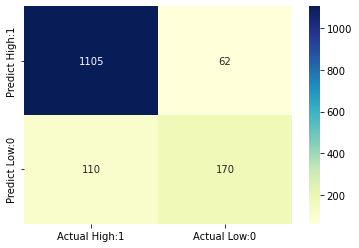

In [38]:
cm_ebm = confusion_matrix(y_test, preds_ebm)
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm_ebm, columns=['Actual High:1', 'Actual Low:0'], 
                                 index=['Predict High:1', 'Predict Low:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [39]:
print(classification_report(y_test, preds_ebm))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1167
           1       0.73      0.61      0.66       280

    accuracy                           0.88      1447
   macro avg       0.82      0.78      0.80      1447
weighted avg       0.88      0.88      0.88      1447



## Random Forest Classifier Model

In [40]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# fit the model to the training set

rfc.fit(X_train, y_train)

# Predict on the test set results

preds_rfc = rfc.predict(X_test)
print('Model accuracy score with 100 decision-trees : {0:0.4f}'. 
      format(accuracy_score(y_test, preds)))

Model accuracy score with 100 decision-trees : 0.8687


In [41]:
#Find important features with Random Forest model 

feature_scores = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

SCREADDIFF                  0.085419
DISCRIM                     0.075629
HOMEPOS                     0.075390
HISEI                       0.071054
ESCS                        0.067794
ATTIMM                      0.059138
JOYREAD                     0.051068
GCAWARE                     0.050604
WORKMAST                    0.046937
GCSELFEFF                   0.042861
PISADIFF                    0.039574
METASUM                     0.039217
AWACOM                      0.032781
BELONG                      0.031415
PERSPECT                    0.030163
DISCLIMA                    0.028627
RESILIENCE                  0.027554
MASTGOAL                    0.024370
TEACHINT                    0.023243
SCREADCOMP                  0.022423
RESPECT                     0.018196
EMOSUPS                     0.015932
GRADE                       0.011170
Is_FISCED_5B_1              0.010072
Is_MISCED_5B_1              0.007916
GENDER_1                    0.005548
REPEAT_Repeated a  grade    0.004407
I

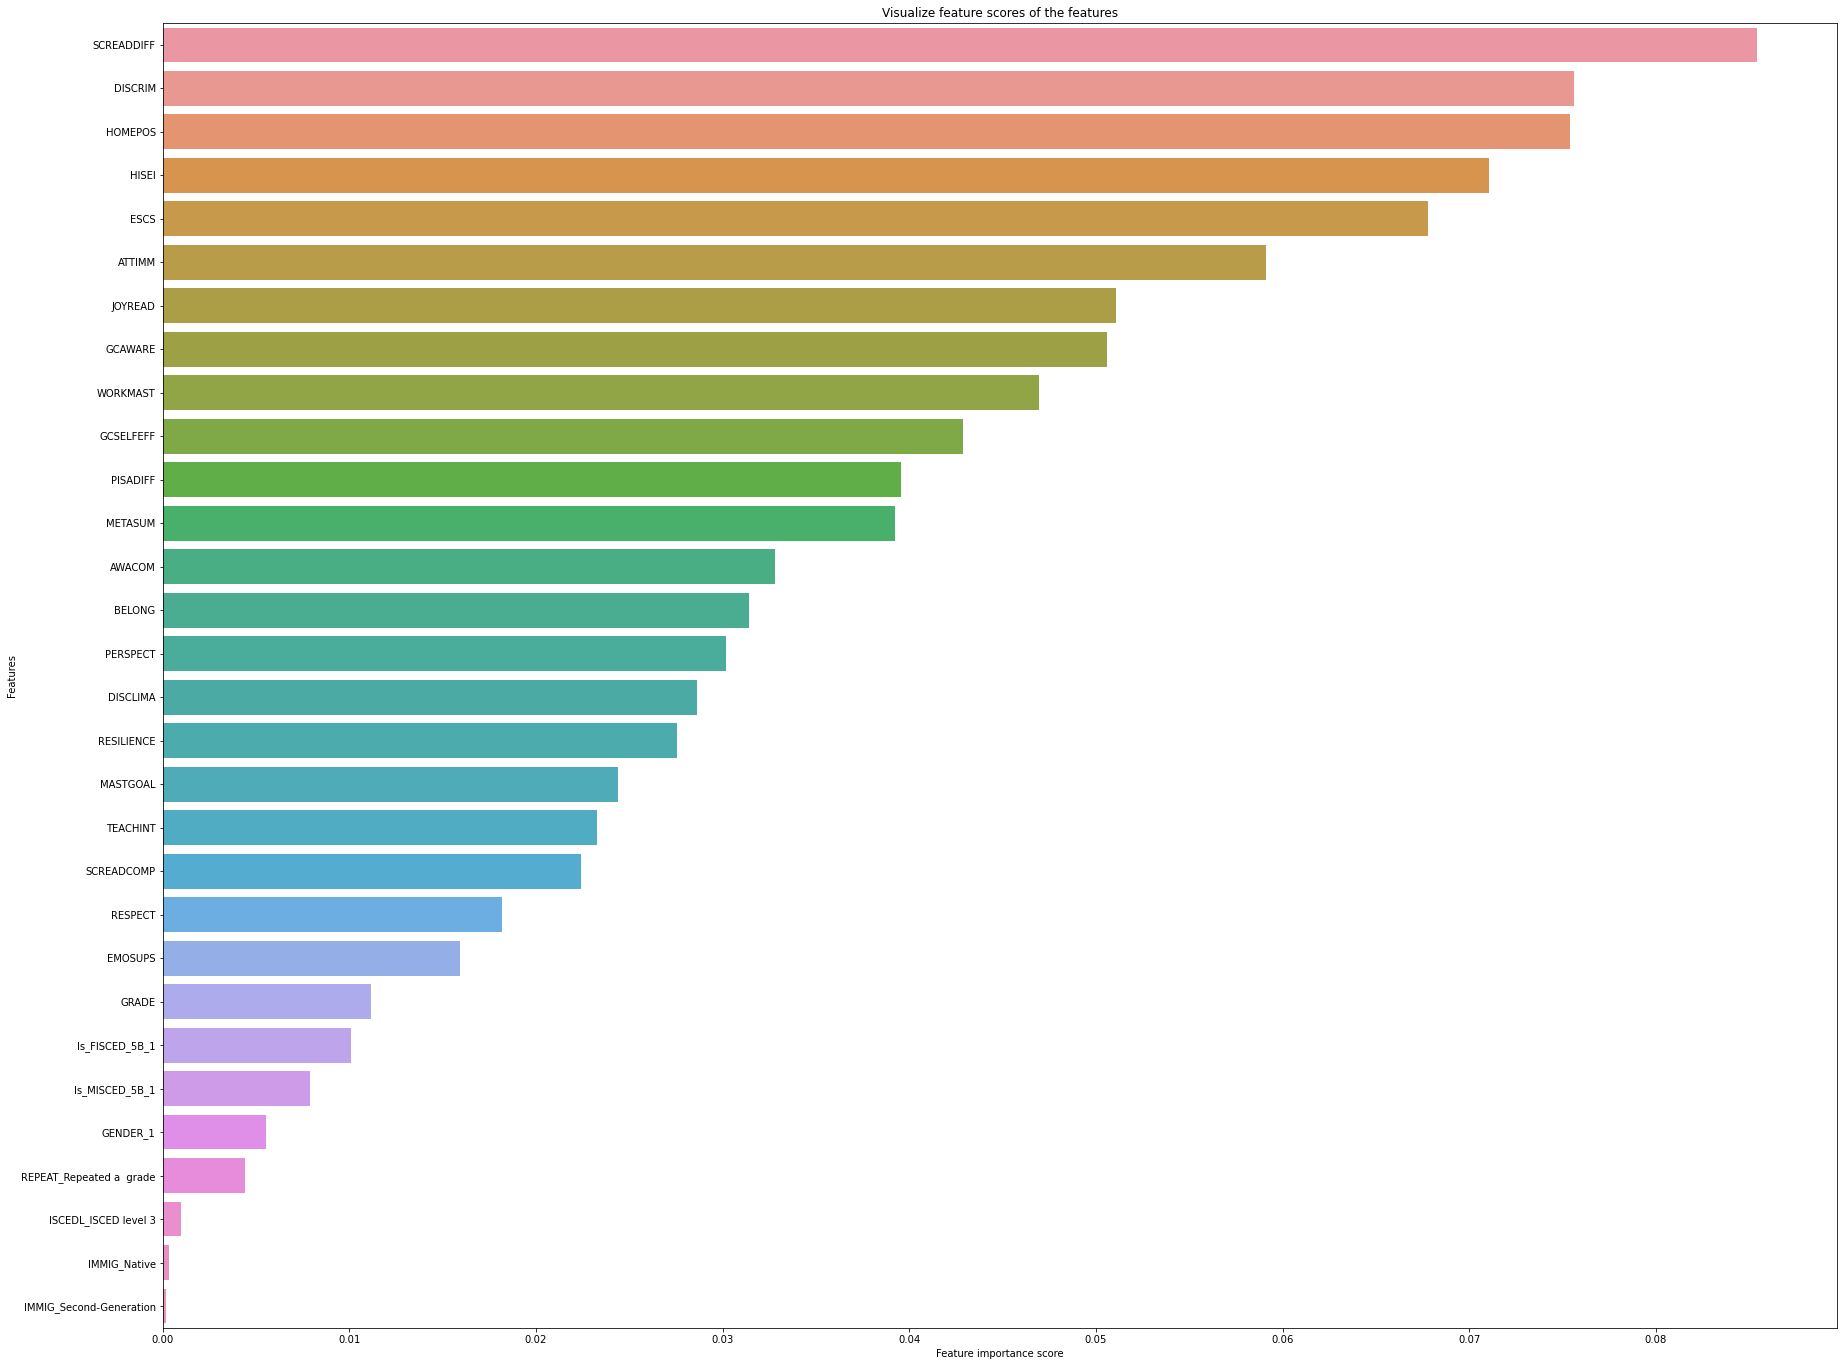

In [42]:
# Creating a seaborn bar plot

f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=train_philippines)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

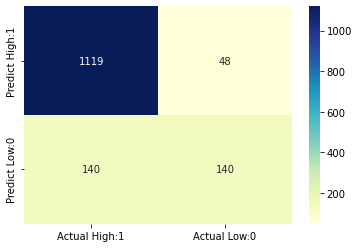

In [43]:
cm_rfc = confusion_matrix(y_test, preds_rfc)
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm_rfc, columns=['Actual High:1', 'Actual Low:0'], 
                                 index=['Predict High:1', 'Predict Low:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [44]:
print(classification_report(y_test, preds_rfc))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1167
           1       0.74      0.50      0.60       280

    accuracy                           0.87      1447
   macro avg       0.82      0.73      0.76      1447
weighted avg       0.86      0.87      0.86      1447



# XGB Classifier model

In [45]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [46]:
xgb = XGBClassifier(n_estimators = 200, learning_rate = 0.5, max_depth = 4)
xgb.fit(X_train_sc, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.5, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [47]:
preds_xgb = xgb.predict(X_test_sc)

In [48]:
# view the feature scores

feature_scores = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

REPEAT_Repeated a  grade    0.188055
SCREADDIFF                  0.083261
ATTIMM                      0.069754
WORKMAST                    0.061894
DISCRIM                     0.053843
Is_FISCED_5B_1              0.052629
METASUM                     0.039934
HISEI                       0.036587
GCAWARE                     0.035344
HOMEPOS                     0.032373
GRADE                       0.030737
MASTGOAL                    0.026227
PISADIFF                    0.024046
GENDER_1                    0.023974
SCREADCOMP                  0.023016
ESCS                        0.022955
GCSELFEFF                   0.021852
JOYREAD                     0.021656
PERSPECT                    0.018088
DISCLIMA                    0.017620
RESPECT                     0.017553
AWACOM                      0.017337
BELONG                      0.017244
RESILIENCE                  0.017149
TEACHINT                    0.016476
Is_MISCED_5B_1              0.015921
EMOSUPS                     0.014477
I

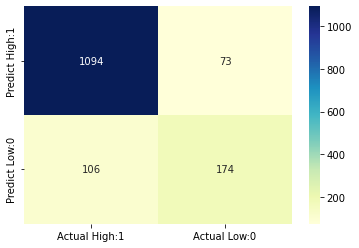

In [49]:
cm_xgb = confusion_matrix(y_test, preds_xgb)
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm_xgb, columns=['Actual High:1', 'Actual Low:0'], 
                                 index=['Predict High:1', 'Predict Low:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [50]:
print(classification_report(y_test, preds_xgb))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1167
           1       0.70      0.62      0.66       280

    accuracy                           0.88      1447
   macro avg       0.81      0.78      0.79      1447
weighted avg       0.87      0.88      0.87      1447



In [51]:
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train_sc)

In [52]:
shap_values

array([[-0.27781084, -0.6275771 ,  0.7156983 , ...,  0.        ,
        -1.167445  ,  0.3368568 ],
       [-0.07134731,  0.8853338 , -0.9657772 , ...,  0.        ,
         0.10916878, -0.35940486],
       [ 0.09636455, -0.43426967, -1.0200901 , ...,  0.        ,
         0.13626596, -0.38776964],
       ...,
       [-0.1230083 ,  1.086343  , -0.21737653, ...,  0.        ,
         0.08277666,  0.34805396],
       [-0.09558073,  0.04327723,  0.21294445, ...,  0.        ,
         0.11338753, -0.30755562],
       [ 0.14047523, -1.1319094 , -0.77793413, ...,  0.        ,
         0.1252331 , -0.35857874]], dtype=float32)

In [53]:
#Local explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:],  pd.DataFrame(X_test, columns =X_test.columns).iloc[0,:])

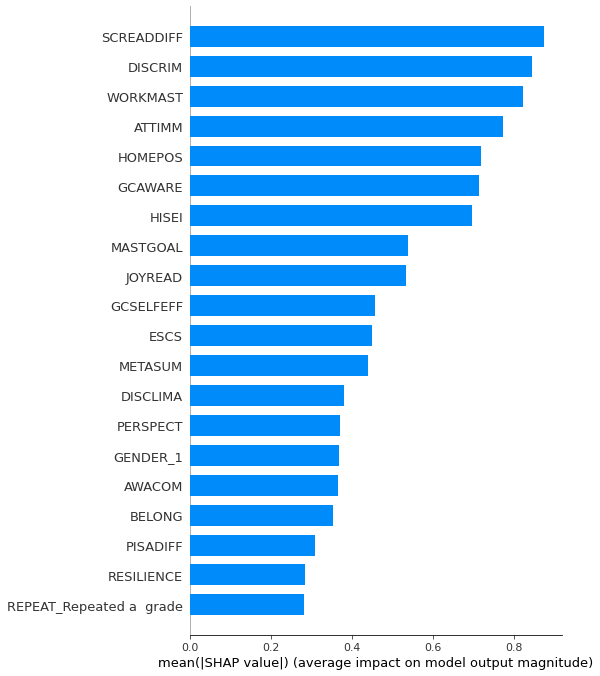

In [54]:
shap.summary_plot(shap_values, X_train_sc, plot_type="bar", feature_names= X_train.columns)

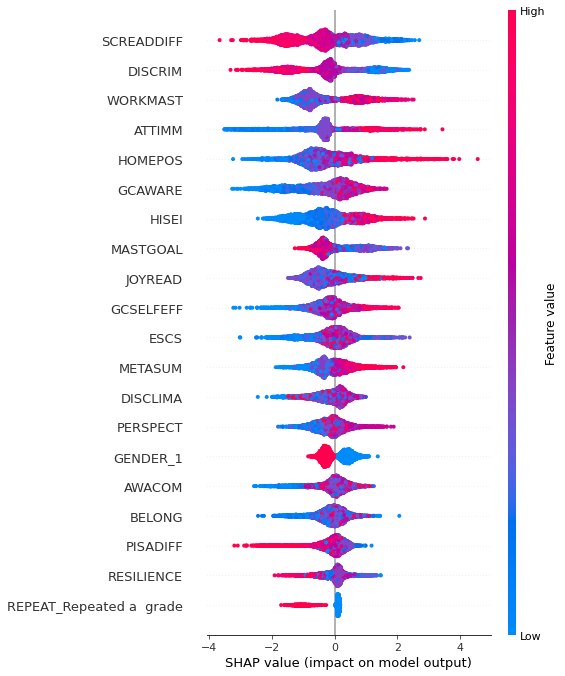

In [55]:
shap.summary_plot(shap_values, X_train)

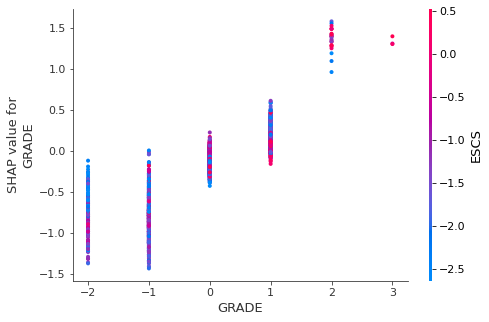

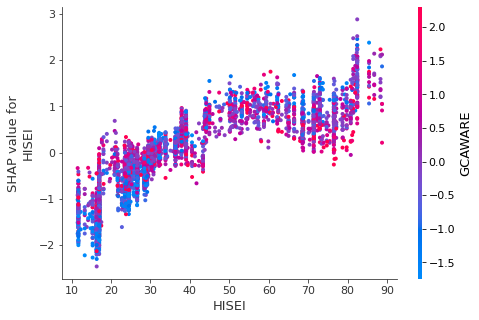

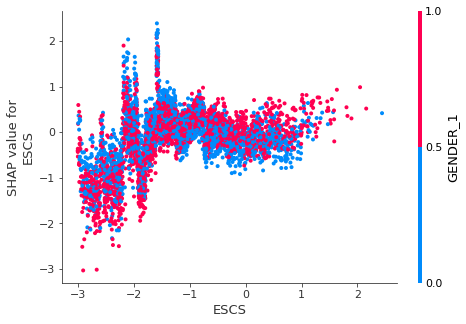

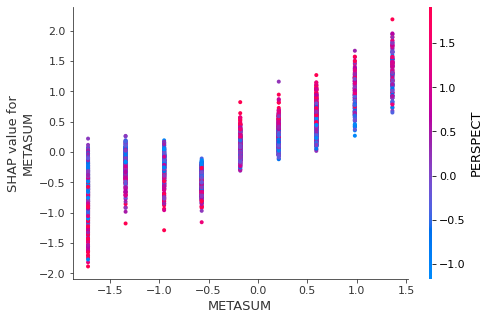

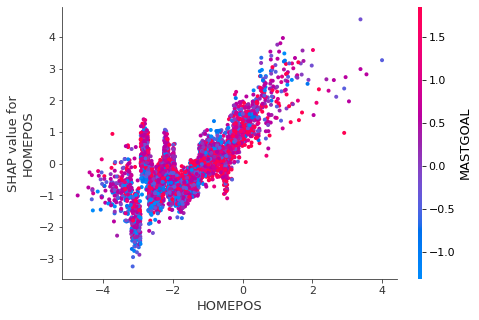

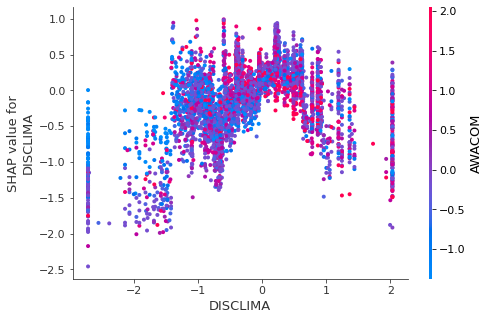

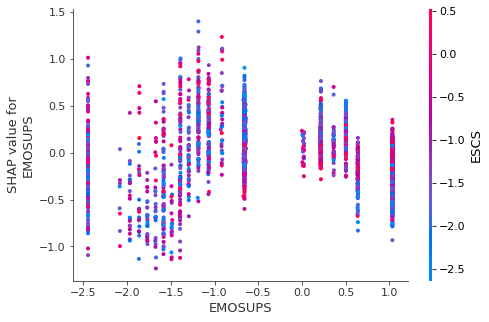

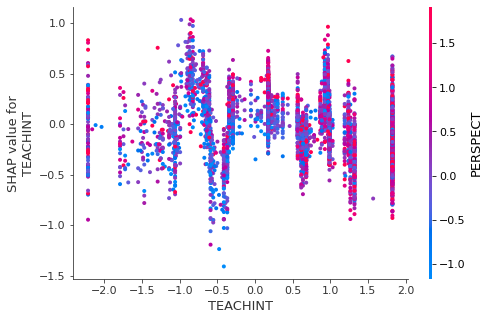

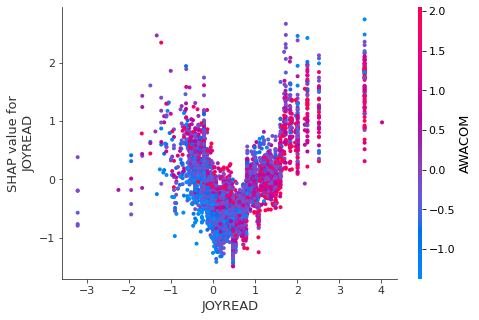

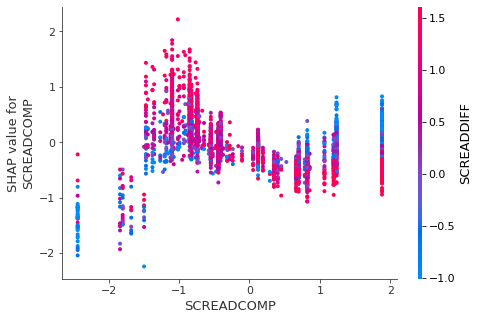

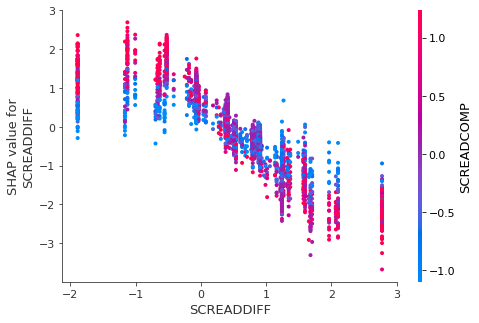

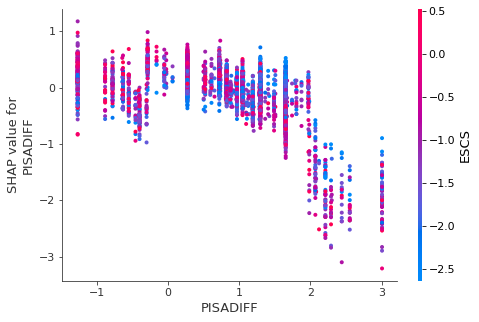

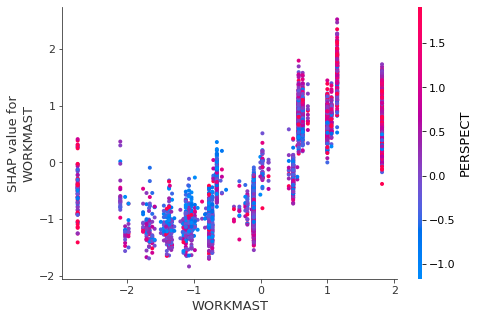

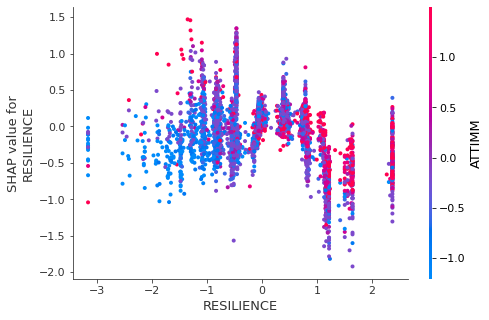

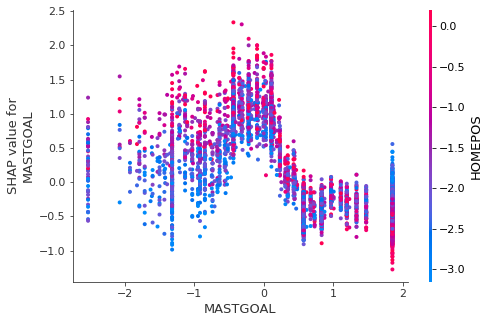

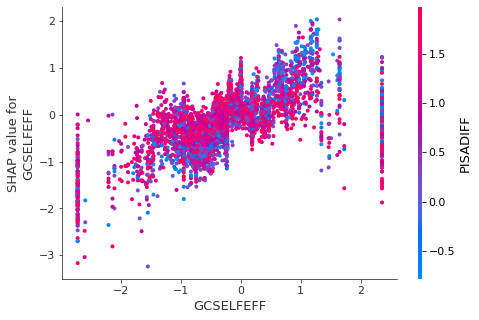

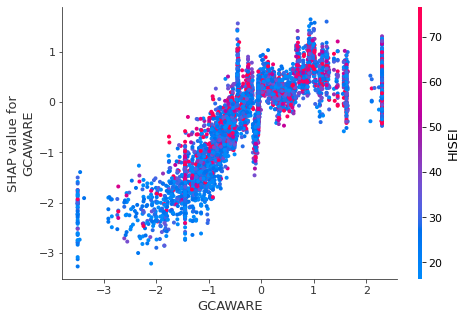

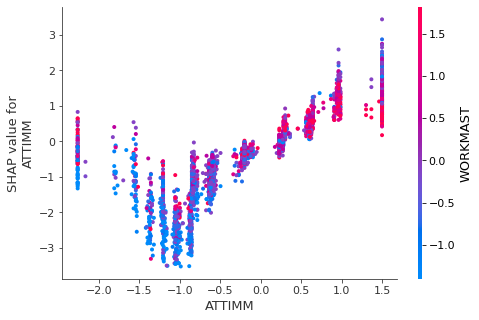

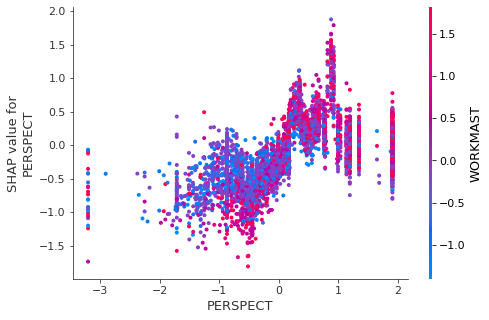

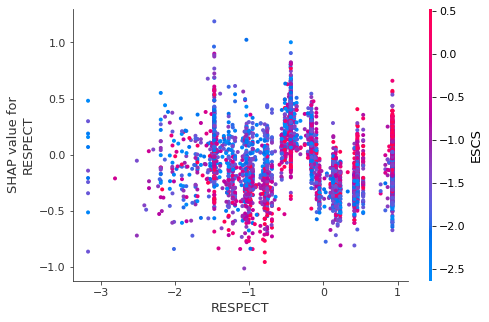

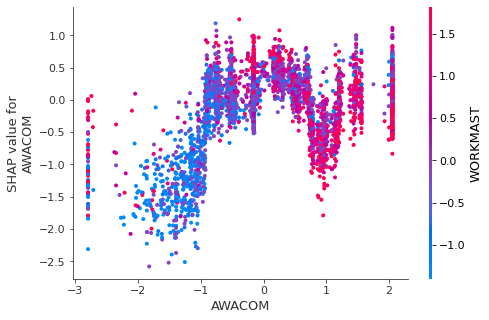

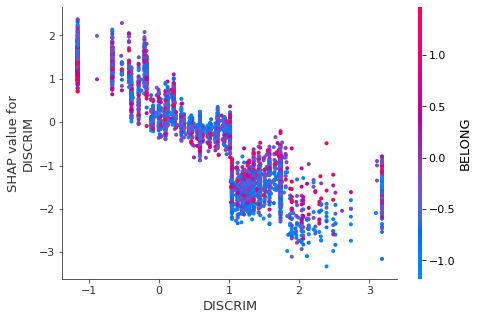

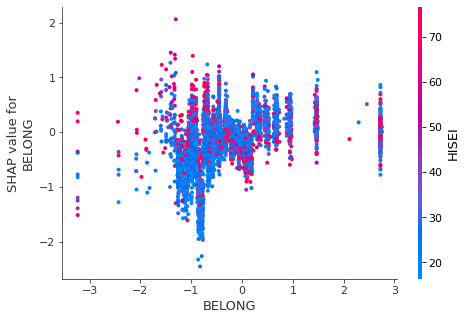

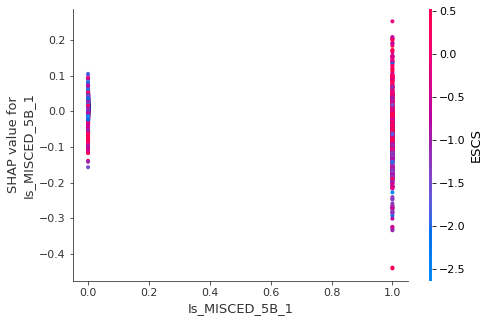

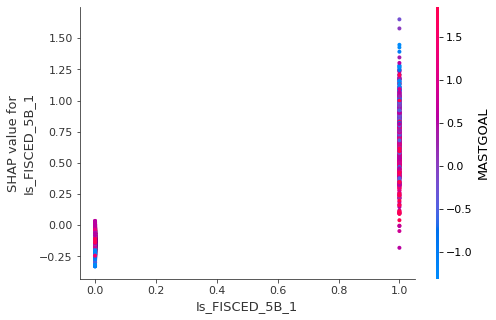

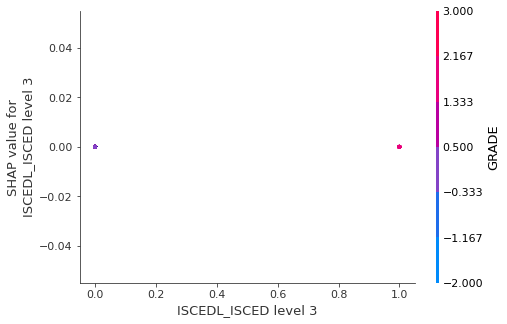

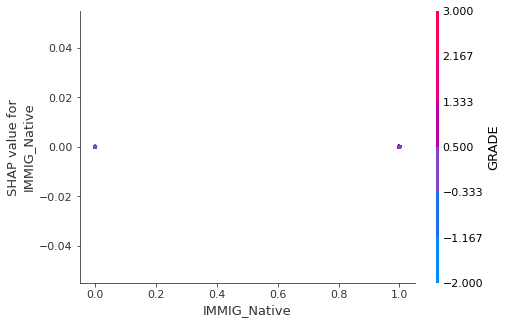

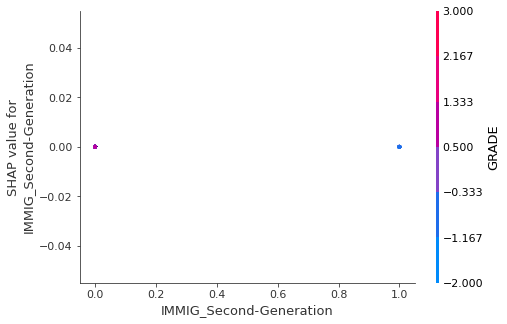

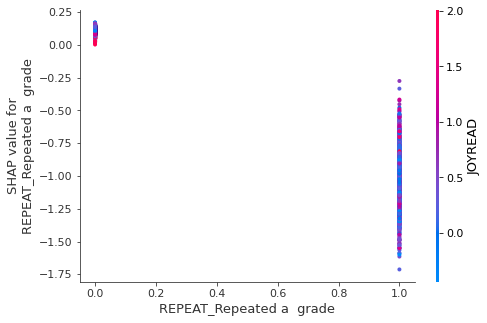

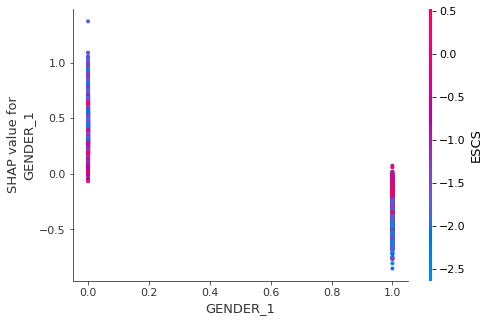

In [56]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train, display_features=X_train)